In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import seaborn as sns
from df_functions import read_csv_file, extract_users, format_data, split_and_reformat, reqs_per_5mins, clean_reqlogs, calculate_variance, count_unique_reqs, longestConsecutive
from vectorize import vectorizer

**Data pre-processing**

Examine:
- the time between requests
- number of requests
- divide data into smaller intervals
- check number of tokens within a 5-minute time frame
- number of requests in a row

In [2]:
data = read_csv_file('requests.csv')
#data

formatted_df = split_and_reformat(data, 'URL')
#formatted_df

df_cleaned = clean_reqlogs(formatted_df)
#df_cleaned['request_logs'].iloc[5]

#users = extract_users(data)
#users

#df_cleaned['request_logs'].iloc[5]
#longestConsecutive(df_cleaned['request_logs'].iloc[5])
#df_cleaned
formatted_df

,users,URL,request_logs
0,user-1003,"/chat/send/442, /chat/send/969, /searchUsers?...",/chat/send/ /chat/send/ /searchusers?page= ...
1,user-1004,"/searchUsers?page=1981, /searchUsers?page=198...",/searchusers?page= /searchusers?page= /chat...
2,user-1005,"/profile/407, /profile/148, /profile/223, /pr...",/profile/ /profile/ /profile/ /profile/ /...
3,user-135,"/profile/111, /profile/951, /conversation/951...",/profile/ /profile/ /conversation/ /conver...
4,user-373,"/searchUsers?page=0, /profile/355",/searchusers?page= /profile/
...,...,...,...
3697,user-565,"/searchUsers?page=0, /profile/423, /conversat...",/searchusers?page= /profile/ /conversation/...
3698,user-618,"/conversation/670, /conversation/670/markAsRe...",/conversation/ /conversation//markasread /i...
3699,user-65,"/profile/278, /conversation/278, /conversatio...",/profile/ /conversation/ /conversation//mar...
3700,user-726,"/login, /searchUsers?page=0, /profile/289, /c...",/login /searchusers?page= /profile/ /conve...


In [32]:
vect = vectorizer(vectorizer='count')

print(df_cleaned['request_logs'])

vect_logs = vect.vectorize_data(df_cleaned['request_logs'])

#Code for checking one user's request_logs
vector_instance=vect_logs[0] 
df_vectorized = pd.DataFrame(vector_instance.T.todense(), index=vect.get_feature_names(), columns=["vect_scores"])
df_vectorized.sort_values(by=["vect_scores"], ascending=False)

0        /chat/send/  /chat/send/  /searchusers?page= ...
1        /searchusers?page=  /searchusers?page=  /chat...
2        /profile/  /profile/  /profile/  /profile/  /...
3        /profile/  /profile/  /conversation/  /conver...
4                           /searchusers?page=  /profile/
                              ...                        
3697     /searchusers?page=  /profile/  /conversation/...
3698     /conversation/  /conversation//markasread  /i...
3699     /profile/  /conversation/  /conversation//mar...
3700     /login  /searchusers?page=  /profile/  /conve...
3701                                               /login
Name: request_logs, Length: 3702, dtype: object


,vect_scores
chat,9
send,9
page,1
searchusers,1
block,0
config,0
conversation,0
inbox,0
like,0
login,0



Some annotations for later
variance normal user[0]: 0.030732589
variance normal user[1]: 0.040072223
variance spammer 1: 0.075907392
variance spammer 2: 0.075314139
variance data scraper: 0.25440979



In [33]:
df_vect_scores = pd.DataFrame(vect_logs.todense(), columns= vect.get_feature_names())
df_vect_scores

,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig
0,0,9,0,0,0,0,0,0,1,0,0,0,1,9,0
1,0,1,0,0,0,0,0,0,2,0,0,0,2,1,0
2,0,0,0,0,0,0,0,0,1,0,15,0,1,0,0
3,1,1,0,2,0,0,0,1,0,0,3,1,0,1,0
4,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,0,2,0,2,0,0,0,1,1,0,2,0,1,2,0
3698,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0
3699,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0
3700,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0


In [34]:
variance_columns = ['profile', 'config', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig']

df_scores = calculate_variance(df_vect_scores, variance_columns)
df_scores = count_unique_reqs(df_scores, variance_columns)

print(df_scores)

      block  chat  config  conversation  inbox  like  login  markasread  page  \
0         0     9       0             0      0     0      0           0     1   
1         0     1       0             0      0     0      0           0     2   
2         0     0       0             0      0     0      0           0     1   
3         1     1       0             2      0     0      0           1     0   
4         0     0       0             0      0     0      0           0     1   
...     ...   ...     ...           ...    ...   ...    ...         ...   ...   
3697      0     2       0             2      0     0      0           1     1   
3698      0     0       0             2      1     0      0           1     1   
3699      0     0       0             2      0     0      0           1     0   
3700      0     0       0             1      0     0      1           0     1   
3701      0     0       0             0      0     0      1           0     0   

      photos  profile  repo

In [35]:
#Code to join the df_cleaned with the tf-idf scores. Try this with Isolation forest if we need to
joined_df = pd.concat([df_cleaned, df_scores], axis = 1)
joined_df

,users,request_logs,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig,var_reqs,unique_reqs
0,user-1003,/chat/send/ /chat/send/ /searchusers?page= ...,0,9,0,0,0,0,0,0,1,0,0,0,1,9,0,9.809524,4
1,user-1004,/searchusers?page= /searchusers?page= /chat...,0,1,0,0,0,0,0,0,2,0,0,0,2,1,0,0.542857,4
2,user-1005,/profile/ /profile/ /profile/ /profile/ /...,0,0,0,0,0,0,0,0,1,0,15,0,1,0,0,14.838095,3
3,user-135,/profile/ /profile/ /conversation/ /conver...,1,1,0,2,0,0,0,1,0,0,3,1,0,1,0,0.809524,7
4,user-373,/searchusers?page= /profile/,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0.171429,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3697,user-565,/searchusers?page= /profile/ /conversation/...,0,2,0,2,0,0,0,1,1,0,2,0,1,2,0,0.780952,7
3698,user-618,/conversation/ /conversation//markasread /i...,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0.380952,4
3699,user-65,/profile/ /conversation/ /conversation//mar...,0,0,0,2,0,0,0,1,0,0,1,0,0,0,0,0.352381,3
3700,user-726,/login /searchusers?page= /profile/ /conve...,0,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0.238095,5


In [40]:
joined_df.loc[joined_df['users'] == ' user-1003']

,users,request_logs,block,chat,config,conversation,inbox,like,login,markasread,page,photos,profile,report,searchusers,send,userconfig,var_reqs,unique_reqs
0,user-1003,/chat/send/ /chat/send/ /searchusers?page= ...,0,9,0,0,0,0,0,0,1,0,0,0,1,9,0,9.809524,4
10,user-1003,/searchusers?page= /searchusers?page= /chat...,0,12,0,0,0,0,0,0,5,0,0,0,5,12,0,18.638095,4
21,user-1003,/searchusers?page= /chat/send/ /searchusers...,0,3,0,0,0,0,0,0,5,0,0,0,5,3,0,3.638095,4
31,user-1003,/searchusers?page= /chat/send/ /searchusers...,0,2,0,0,0,0,0,0,3,0,0,0,3,2,0,1.380952,4
38,user-1003,/chat/send/,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.123810,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3659,user-1003,/searchusers?page= /chat/send/ /searchusers...,0,1,0,0,0,0,0,0,2,0,0,0,2,1,0,0.542857,4
3673,user-1003,/searchusers?page= /chat/send/ /searchusers...,0,1,0,0,0,0,0,0,2,0,0,0,2,1,0,0.542857,4
3680,user-1003,/searchusers?page= /chat/send/ /chat/send/ ...,0,8,0,0,0,0,0,0,3,0,0,0,3,8,0,8.123810,4
3688,user-1003,/searchusers?page= /chat/send/,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0.209524,4


**Isolation Forest**

In [37]:
df_anomaly = df_vect_scores

#all features as anomaly inputs
#anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'config', 'conversation', 'inbox', 'report', 'send', 'userconfig', 'like', 'login', 'markasread', 'photos', 'unique_reqs', 'var_reqs']

#selected features as anomaly inputs (most significant features fpr user 903 are removed)
#anomaly_inputs = ['profile', 'page', 'searchusers', 'block', 'chat', 'conversation', 'inbox', 'report', 'send', 'like', 'login', 'markasread', 'photos', 'userconfig', 'var_reqs', 'unique_reqs']

#only higher level features as inputs
anomaly_inputs = ['var_reqs', 'send']

model_if = IsolationForest(contamination=0.010, random_state=42)
model_if.fit(df_anomaly[anomaly_inputs])

c:\Users\vhage\Documents\Skolarbete\Exjobb\request-analyzer-model\.venv\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, random_state=42)

In [38]:
df_anomaly['anomaly_score'] = model_if.decision_function(df_anomaly[anomaly_inputs])
df_anomaly['anomaly'] = model_if.predict(df_anomaly[anomaly_inputs])

#This dataframe will only include anomaly score and anomaly label
df_anomaly_score = df_anomaly.loc[:,['anomaly_score', 'anomaly']]
df_anomaly_score.loc[df_anomaly_score['anomaly']==-1] 

,anomaly_score,anomaly
161,-0.001954,-1
259,-0.009340,-1
626,-0.017054,-1
713,-0.034376,-1
715,-0.060049,-1
768,-0.001954,-1
853,-0.027517,-1
855,-0.043514,-1
939,-0.026484,-1
941,-0.017054,-1


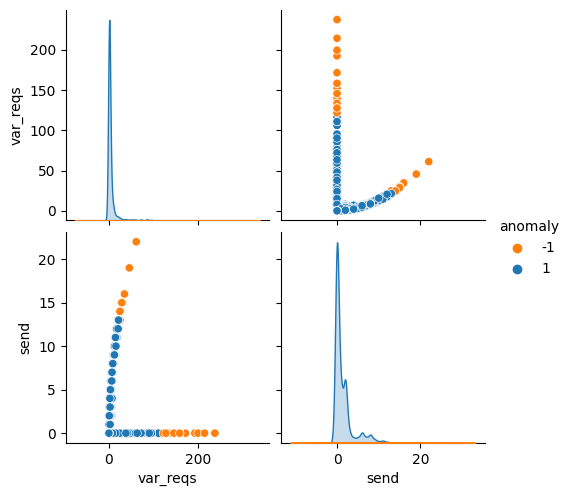

In [39]:
#Plots showcasing the outliers detected by isolation forest
palette = ['#ff7f0e', '#1f77b4']
sns.pairplot(df_vect_scores, vars=anomaly_inputs, hue='anomaly', palette=palette)

**Testing out TSNE**

In [10]:
#Visualizing data with t-SNE
embedded_data = TSNE(perplexity=50.0, n_iter=2000).fit_transform(np.asarray(vect_logs.todense()))
spammer1 = embedded_data[5]
spammer2 = embedded_data[6]
dataScraper = embedded_data[7]

c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\rosin\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [11]:
plt.scatter(embedded_data[:,0], embedded_data[:,1])
plt.scatter(spammer1[0],spammer1[1], color='red')
plt.scatter(spammer2[0],spammer2[1], color='red')
plt.scatter(dataScraper[0],dataScraper[1], color='green')

**PCA: for dimension reduction**

In [12]:
X = np.asarray(vect_logs.todense())
pca = PCA()
pc = pca.fit_transform(X)
pc = pd.DataFrame(pc)
print(pc.shape)
pc

(1245, 15)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-92.945228,50.643983,-3.816285,12.458068,0.435582,-0.222032,0.759090,-0.089186,-0.149554,-0.375728,-0.033748,-0.035497,-6.720520e-15,3.922331e-15,1.736975e-17
1,-89.420142,50.809706,-6.274957,21.659487,-0.020484,0.391818,0.558826,0.248297,-0.454415,-0.433416,-0.039340,-0.031004,4.939605e-14,2.421845e-17,2.740885e-18
2,97.677677,183.877804,-2.580482,-4.250594,1.044697,-1.227026,1.208709,-0.569416,0.218719,-0.354963,-0.046571,-0.054305,9.370763e-17,-3.745269e-16,1.051614e-17
3,2.489835,-1.604795,2.480169,-0.310569,-0.027913,0.443134,-0.190589,0.857431,-0.417273,-0.401455,-0.007244,0.010453,-3.486704e-16,-1.222273e-15,9.392140e-18
4,3.969299,-4.522695,2.035218,0.913813,-0.170490,-0.525783,0.426319,-0.178166,-0.196157,-0.029000,-0.011050,-0.002145,-2.035893e-16,-1.580528e-15,-2.546331e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1240,3.155548,-6.652721,-2.011735,-1.113848,0.249749,-0.238946,0.382780,-0.205801,0.003119,-0.129554,-0.003107,-0.013923,2.923543e-16,1.914016e-16,1.338726e-19
1241,2.931142,-4.337670,0.340263,-1.377959,-0.463048,-0.061618,-0.202363,-0.020606,-0.067550,0.128108,0.005254,0.015424,5.117986e-16,8.835742e-17,1.697933e-18
1242,4.465878,-3.659194,3.366996,0.988760,-0.850713,-0.226790,-0.192515,0.032928,-0.239334,0.205059,-0.448052,0.033774,-7.059700e-17,1.056654e-16,3.232775e-18
1243,1.985833,-2.471050,0.374085,-0.490312,2.146406,-0.357944,-1.386729,0.135648,-0.000262,-0.581427,-0.024220,0.010383,9.293606e-17,3.773174e-17,1.019156e-17


In [13]:
print("Eigen values: ", list(np.round(pca.explained_variance_, decimals=5)))
print("PCA_variance_ratio: ", pca.explained_variance_ratio_)
print(pca.n_components)

Eigen values:  [133.60292, 115.21701, 9.91979, 4.40628, 0.64315, 0.24733, 0.15943, 0.13664, 0.10045, 0.0392, 0.00636, 0.00584, 0.0, 0.0, 0.0]
PCA_variance_ratio:  [5.05144823e-01 4.35628779e-01 3.75061316e-02 1.66598768e-02
 2.43170337e-03 9.35142004e-04 6.02807321e-04 5.16621461e-04
 3.79797369e-04 1.48195446e-04 2.40403547e-05 2.20816115e-05
 9.11745551e-33 1.82902489e-34 1.13010028e-37]
None
